In [ ]:
# data analysis
import pandas as pd
import numpy as np


# visualization
import seaborn as sns
import matplotlib.pyplot as plt

import kagglehub
import os

# Pre-Processing and Training
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Baixando Dataset

In [ ]:
# Download latest version
path = kagglehub.dataset_download("ruchikakumbhar/obesity-prediction")
path = os.path.join(path, os.listdir(path)[0])
print(path)

100%|██████████| 57.5k/57.5k [00:00<00:00, 12.3MB/s]

Extracting files...
/root/.cache/kagglehub/datasets/ruchikakumbhar/obesity-prediction/versions/1/Obesity prediction.csv


In [ ]:
df = pd.read_csv(path)
df.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [ ]:
print(df.shape)
df.info()

(2111, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          2111 non-null   object 
 1   Age             2111 non-null   float64
 2   Height          2111 non-null   float64
 3   Weight          2111 non-null   float64
 4   family_history  2111 non-null   object 
 5   FAVC            2111 non-null   object 
 6   FCVC            2111 non-null   float64
 7   NCP             2111 non-null   float64
 8   CAEC            2111 non-null   object 
 9   SMOKE           2111 non-null   object 
 10  CH2O            2111 non-null   float64
 11  SCC             2111 non-null   object 
 12  FAF             2111 non-null   float64
 13  TUE             2111 non-null   float64
 14  CALC            2111 non-null   object 
 15  MTRANS          2111 non-null   object 
 16  Obesity         2111 non-null   object 
dtypes: float64(8), object(

Após verificação, entende-se que o dataset não conta com campos nulos, logo, não será necessário tratamento de nulos.

## 🔍 Análise e Preparação dos Dados

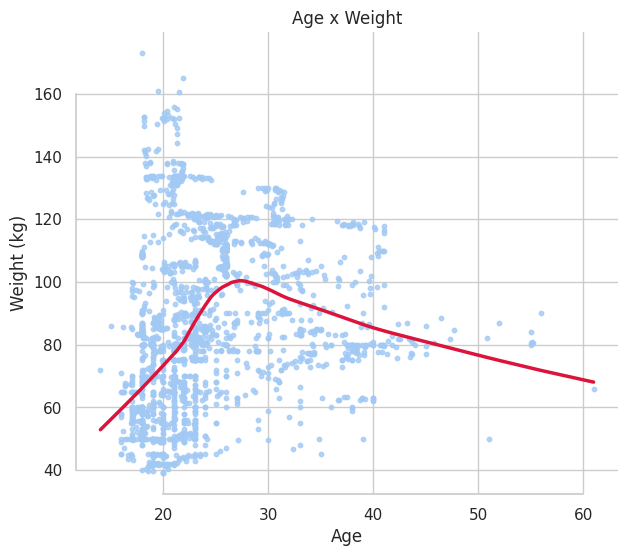

In [ ]:
ageWeight = df[['Age', 'Weight']]

f, ax = plt.subplots(figsize=(7, 6))

sns.regplot(
    data=ageWeight,
    x='Age', y='Weight',
    ax=ax,lowess=True,
    scatter_kws={'s':40},
    marker='.',
    line_kws={'color': 'crimson', 'lw': 2.5})


# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel = "Weight (kg)", xlabel = "Age", title="Age x Weight")
sns.despine(trim=True)


In [ ]:
# Feature Engineering

df['IMC'] = (df['Weight'] / np.power(df['Height'], 2)).round(2)

df.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity,IMC
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight,24.39
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,24.24
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,23.77
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,26.85
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,28.34


In [ ]:
f = lambda col:print(f"{col}: {df[col].unique() if (len(df[col].unique())<10) else None}")

for col in df:
  f(col)

Gender: ['Female' 'Male']
Age: None
Height: None
Weight: None
family_history: ['yes' 'no']
FAVC: ['no' 'yes']
FCVC: None
NCP: None
CAEC: ['Sometimes' 'Frequently' 'Always' 'no']
SMOKE: ['no' 'yes']
CH2O: None
SCC: ['no' 'yes']
FAF: None
TUE: None
CALC: ['no' 'Sometimes' 'Frequently' 'Always']
MTRANS: ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
Obesity: ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


### Verificando respostas colunas categóricas

In [ ]:
# 'cols' representam as colunas categóricas do dataset

cols = ['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'Obesity']
for col in cols:
  print('\n', df[col].value_counts())



 Gender
Male      1068
Female    1043
Name: count, dtype: int64

 family_history
yes    1726
no      385
Name: count, dtype: int64

 FAVC
yes    1866
no      245
Name: count, dtype: int64

 CAEC
Sometimes     1765
Frequently     242
Always          53
no              51
Name: count, dtype: int64

 SMOKE
no     2067
yes      44
Name: count, dtype: int64

 SCC
no     2015
yes      96
Name: count, dtype: int64

 CALC
Sometimes     1401
no             639
Frequently      70
Always           1
Name: count, dtype: int64

 MTRANS
Public_Transportation    1580
Automobile                457
Walking                    56
Motorbike                  11
Bike                        7
Name: count, dtype: int64

 Obesity
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64


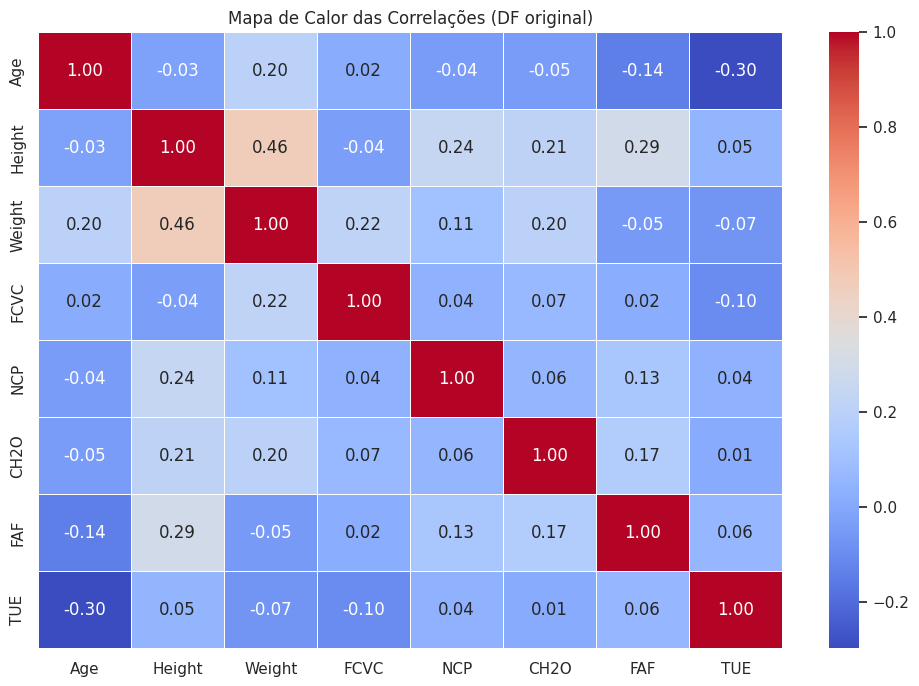

In [ ]:
corr = df.corr(numeric_only=True)

# Plotar o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Mapa de Calor das Correlações (DF original)")
plt.show()

#Divisão de teste e treino
A coluna escolhida para previsão foi a *Obesity*.
Dentro do dataset, 80% dos dados foram separados para treinamento do modelo e o resto para teste.

In [ ]:
X = df.drop('Obesity', axis=1)
y = df['Obesity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

##One-Hot Encoding


###Pré-Processamento
O método ColumnTransformer foi utilizado para aplicar o One-Hot Enconding nas colunas categóricas

In [ ]:
categorical = ['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

preprocessador = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ],
    remainder = 'passthrough' # Colunas não especificadas serão mantidas no dataset
)

In [ ]:
def avalia_modelo(model, X_train= X_train, y_train= y_train, X_test= X_test, y_test= y_test):
    model = pipeline.fit(X_train, y_train)
    accuracy = pipeline.score(X_test, y_test)
    print(f"Acurácia no conjunto de teste usando modelo {modelo}: {accuracy:.2f}")

modelos = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=100000), # Large number of iterations suggested by the own library
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier()
}

###Pipeline

In [ ]:
for nome, modelo in modelos.items():

  pipeline = Pipeline(steps = [
      ('preprocessamento', preprocessador),
      ('modelo', modelo)
  ]
  )

  avalia_modelo(modelo)

Acurácia no conjunto de teste usando modelo RandomForestClassifier(): 0.94
Acurácia no conjunto de teste usando modelo LogisticRegression(max_iter=100000): 0.86
Acurácia no conjunto de teste usando modelo SVC(): 0.57
Acurácia no conjunto de teste usando modelo DecisionTreeClassifier(): 0.94


###Featura Importances

In [ ]:
# Acessa o modelo RandomForest treinado dentro do pipeline
modelo_treinado = pipeline.named_steps['modelo']

# Acessa o OneHotEncoder
encoder = pipeline.named_steps['preprocessamento'].named_transformers_['cat']

# Pega os nomes das colunas one-hot encoded
nomes_onehot = encoder.get_feature_names_out(categorical)

# Como usou 'remainder="passthrough"', concatena com as colunas numéricas (na ordem original)
colunas_finais = list(nomes_onehot) + list(X.select_dtypes(exclude='object').columns)

# Exibe importância das features
importancias = modelo_treinado.feature_importances_
importancia_df = pd.DataFrame({'feature': colunas_finais, 'importancia': importancias})
importancia_df = importancia_df.sort_values(by='importancia', ascending=False)

print(importancia_df.head(10))


          feature  importancia
25         Weight     0.279426
23            Age     0.091235
26           FCVC     0.085817
24         Height     0.083857
27            NCP     0.054046
29            FAF     0.045672
30            TUE     0.045313
28           CH2O     0.043134
0   Gender_Female     0.034098
1     Gender_Male     0.032918
